In [27]:
import simon_64_128
import logger
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [19]:
NUM_MEASUREMENTS = 1000
VALS_PER_MEASUREMENT = 45

In [3]:
def get_x_values_from_log(log: logger.Log) -> np.ndarray:
    x_values = []
    for e in log.entries:
        if e.label.startswith("X"):
            x_values.append(e.content)
    return np.array(x_values, dtype=np.uint32)

def log_to_measurement(log: logger.Log) -> np.ndarray:
    x_values = get_x_values_from_log(log)
    return np.bitwise_count(x_values)

In [4]:
def get_x_for_guessed_key(plaintext: np.ndarray, guessed_key: np.ndarray, round: int) -> np.integer:
    x_values = simon_64_128.encrypt_block_light(plaintext, guessed_key)
    return x_values[round]

def get_hw_for_guessed_key_byte(plaintext: np.ndarray, guessed_key: np.ndarray, round: int, mask: int) -> int:
    x_i = get_x_for_guessed_key(plaintext, guessed_key, round)
    return (x_i & mask).bit_count()

In [5]:
def find_max_correlation(expected_hws: np.ndarray, consumptions: np.ndarray) -> np.float64:
    """ Go through all timepoints and find the one with the highest correlation to the hamming weights.
    Example: 
        - 1000 measurements, each with 45 timepoints
        - expected_hws: [8, ..., 1] # Shape = 1000
        - consumptions: [[27, ...,  17], 
                         [30, ...,   2], 
                         ... 
                         [11, ...,  11]] # Shape = (1000, 45)
                           |    |    |
                          0.5  ...  0.1  <- Correlations for each timepoint
        - returns 0.5

    """
    assert expected_hws.shape[0] == consumptions.shape[0]
    
    correlations = np.array([np.corrcoef(expected_hws, consumptions[:, t])[0, 1] for t in range(consumptions.shape[1])], dtype=np.float64)
    return np.max(correlations)

In [6]:
def array_to_hex_str(val: np.ndarray) -> str:
    return " ".join(f"0x{e:02X}" for e in val)

In [114]:
key = rng.integers(0, 2**32, 4, dtype=np.uint32)

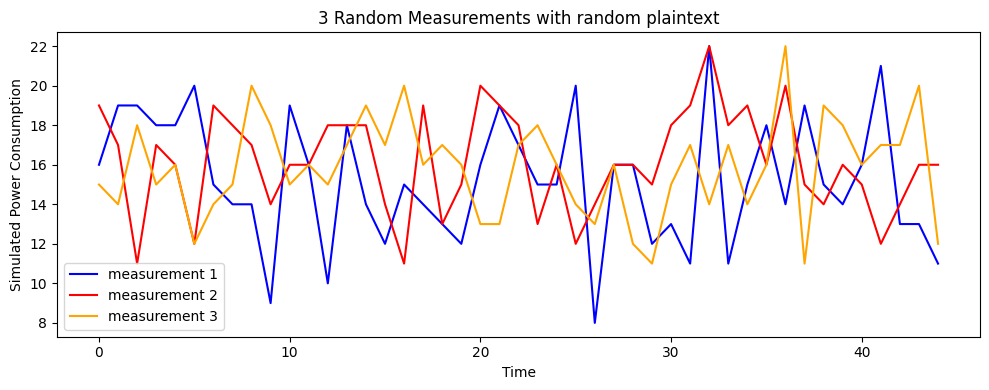

In [119]:
 # Perform 1000 simulated measurements
measurements = []

for i in range(NUM_MEASUREMENTS):
    plaintext = rng.integers(0, 2**32, 2, dtype=np.uint32)
    ciphertext, log = simon_64_128.encrypt_block(plaintext, key)
    current_consumption = log_to_measurement(log)

    measurements.append((plaintext, ciphertext, current_consumption))

plt.figure(figsize=(10,4))
vals1 = measurements[0][2]
vals2 = measurements[1][2]
vals3 = measurements[2][2]

plt.plot(vals1, color='blue', label='measurement 1')
plt.plot(vals2, color='red', label='measurement 2')
plt.plot(vals3, color='orange', label='measurement 3')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Random Measurements with random plaintext")
plt.tight_layout()
plt.show()

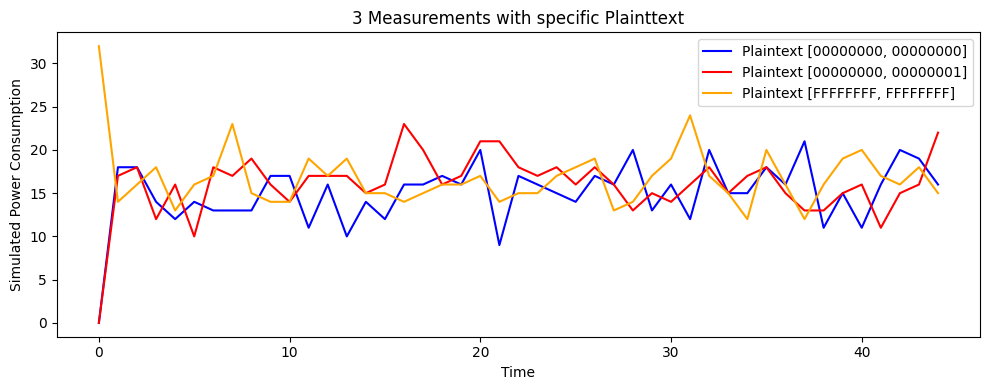

In [120]:
plaintext1 = np.array([0,0], dtype=np.uint32)
_, log1 = simon_64_128.encrypt_block(plaintext1, key)

plaintext2 = np.array([0,1], dtype=np.uint32)
_, log2 = simon_64_128.encrypt_block(plaintext2, key)

plaintext3 = np.array([0xFFFFFFFF,0xFFFFFFFF], dtype=np.uint32)
_, log3 = simon_64_128.encrypt_block(plaintext3, key)

current_consumption1 = log_to_measurement(log1)
current_consumption2 = log_to_measurement(log2)
current_consumption3 = log_to_measurement(log3)


plt.figure(figsize=(10,4))
vals1 = current_consumption1
vals2 = current_consumption2
vals3 = current_consumption3

plt.plot(vals1, color='blue', label='Plaintext [00000000, 00000000]')
plt.plot(vals2, color='red', label='Plaintext [00000000, 00000001]')
plt.plot(vals3, color='orange', label='Plaintext [FFFFFFFF, FFFFFFFF]')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Simulated Power Consumption")
plt.title("3 Measurements with specific Plainttext")
plt.tight_layout()
plt.show()

In [9]:
ATTACK_TABLE = [
    # Key word, Cipher Round to Attack, Byte Shift within key word
    (3, 0, 0),
    (3, 0, 8),
    (3, 0, 16),
    (3, 0, 24),
    (2, 1, 0),
    (2, 1, 8),
    (2, 1, 16),
    (2, 1, 24),
    (1, 2, 0),
    (1, 2, 8),
    (1, 2, 16),
    (1, 2, 24),
    (0, 3, 0),
    (0, 3, 8),
    (0, 3, 16),
    (0, 3, 24),
]


In [121]:
# Go through all measurements and get current consumption as 2D-array
consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)

# start with empty key
current_key = np.zeros((4,), dtype=np.uint32)

for attack_idx, attack_spec in enumerate(ATTACK_TABLE):
    print(f"Perform Attack Step {attack_idx+1}/{len(ATTACK_TABLE)}")
    key_word_idx = attack_spec[0]
    round_to_attack = attack_spec[1]
    byte_shift = attack_spec[2]
    byte_mask = 0xFF << byte_shift

    # Prepare a table with correlations for each possible byte value
    key_corrs = np.zeros((256,), dtype=np.float32)

    for guessed_byte in range(256):
        guessed_key = current_key.copy()
        guessed_key[key_word_idx] |= guessed_byte << byte_shift

        # Go through all measurements and get expected hamming weights for guessed byte as 1D-array
        predicted_hws = np.array(
                [get_hw_for_guessed_key_byte(m[0], guessed_key, round_to_attack, byte_mask) for m in measurements], 
                dtype=np.uint32)

        # Find max correlation for current guessed byte
        max_corr = find_max_correlation(predicted_hws, consumptions)
        key_corrs[guessed_byte] = max_corr

    max_corr_total = np.max(key_corrs)
    key_byte = np.argmax(key_corrs)
    print(f"Best guess for key byte {attack_idx}: 0x{key_byte:02X}, Correlation: {max_corr_total}. Second best correlation: {np.partition(key_corrs.flatten(), -2)[-2]}")
    current_key[key_word_idx] |= key_byte << byte_shift

print(f"Best guess for complete key: {array_to_hex_str(current_key)}")


Perform Attack Step 1/16
Best guess for key byte 0: 0x15, Correlation: 0.49039098620414734. Second best correlation: 0.38343557715415955
Perform Attack Step 2/16
Best guess for key byte 1: 0x9B, Correlation: 0.494762122631073. Second best correlation: 0.39048781991004944
Perform Attack Step 3/16
Best guess for key byte 2: 0xBE, Correlation: 0.5327019095420837. Second best correlation: 0.4291796386241913
Perform Attack Step 4/16
Best guess for key byte 3: 0x2B, Correlation: 0.47513124346733093. Second best correlation: 0.3771948516368866
Perform Attack Step 5/16
Best guess for key byte 4: 0x1A, Correlation: 0.5063552260398865. Second best correlation: 0.4285668730735779
Perform Attack Step 6/16
Best guess for key byte 5: 0x22, Correlation: 0.4700393080711365. Second best correlation: 0.3754158616065979
Perform Attack Step 7/16
Best guess for key byte 6: 0x1C, Correlation: 0.5206473469734192. Second best correlation: 0.39678534865379333
Perform Attack Step 8/16
Best guess for key byte 7:

In [122]:
print(f"Actual key: {array_to_hex_str(key)}")

print(f"Differences: {array_to_hex_str(current_key ^ key)}")

Actual key: 0xCADCC556 0x3D90B208 0x1A1C221A 0x2BBE9B15
Differences: 0x00 0x00 0x00 0x00


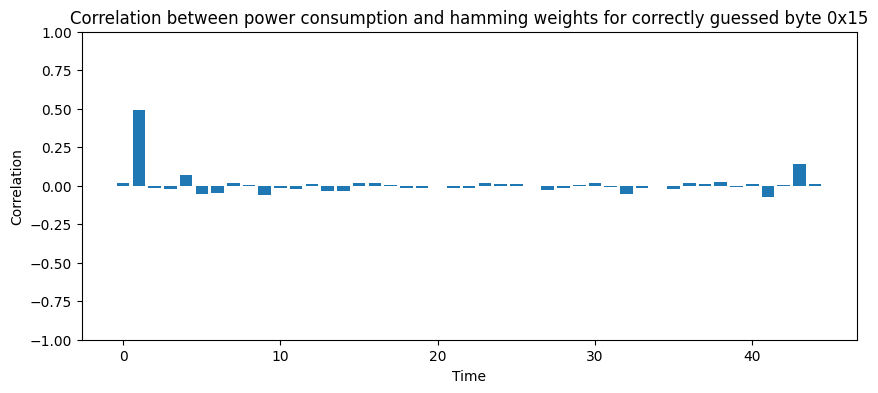

In [124]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = key[3] & 0xFF
guessed_key[3] |= guessed_byte

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for correctly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()

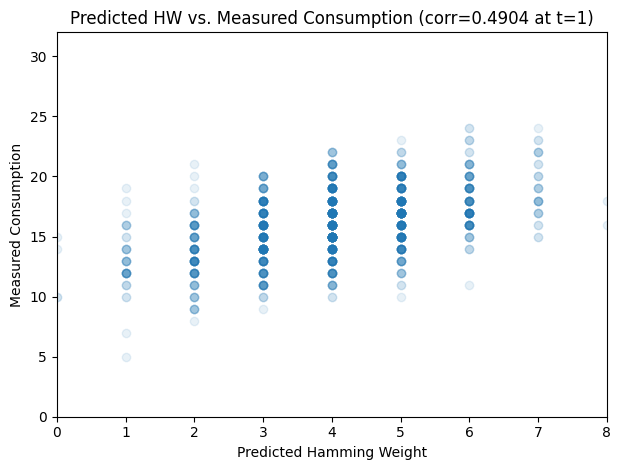

In [ ]:
# Print correlation for a correct key byte

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_key[3] = key[3] & 0xFF

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

# find the index where correlation is highest
max_corr_index = np.argmax(corrs)
consumptions_with_best_corr = consumptions[:, max_corr_index]

plt.scatter(predicted_hws, consumptions_with_best_corr, alpha=0.1)
plt.xlabel("Predicted Hamming Weight")
plt.ylabel("Measured Consumption")
plt.title(f"Predicted HW vs. Measured Consumption")
plt.tight_layout()
plt.xlim(0, 8)
plt.ylim(0, 32)
plt.show()


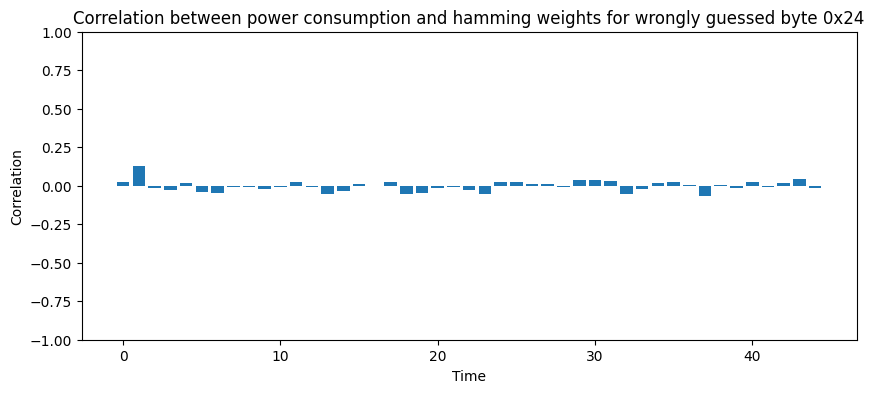

In [127]:
# Print correlation in comparison to time

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_byte = (key[3] & 0xFF) + 15
guessed_key[3] |= guessed_byte

predicted_hws = np.array(
        [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
        dtype=np.uint32)

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)
corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for wrongly guessed byte 0x{guessed_byte:02X}")
plt.ylim(-1, 1)
plt.show()

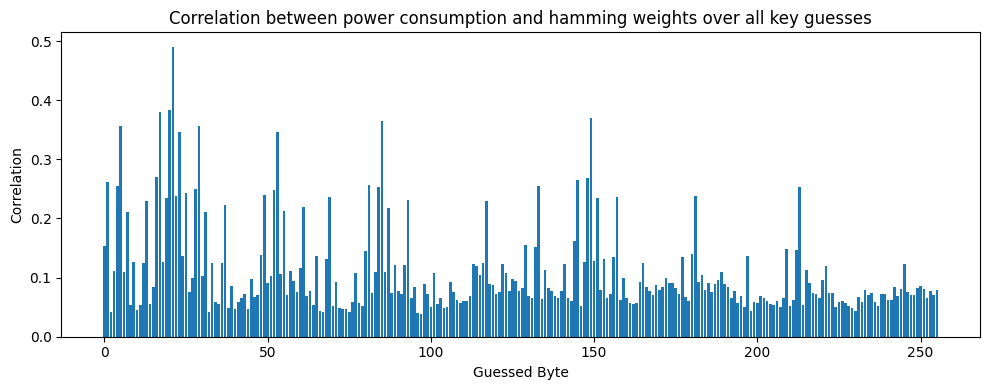

In [128]:
# Print max correlation for all guessed bytes

consumptions = np.array([m[2] for m in measurements], dtype=np.uint32)

max_corrs = np.zeros((256,), dtype=np.float64)


guessed_key = np.zeros((4,), dtype=np.uint32)
for guessed_byte in range(256):
    guessed_key[3] = guessed_byte

    predicted_hws = np.array(
            [get_hw_for_guessed_key_byte(m[0], guessed_key, 0, 0xFF) for m in measurements], 
            dtype=np.uint32)


    corrs = np.array([np.corrcoef(predicted_hws, consumptions[:, t])[0, 1] for t in range(VALS_PER_MEASUREMENT)], dtype=np.float64)
    max_corrs[guessed_byte] = np.max(corrs)

plt.figure(figsize=(10,4))
x = np.arange(len(max_corrs))
plt.bar(x, max_corrs)
plt.xlabel("Guessed Byte")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights over all key guesses")
plt.tight_layout()
plt.show()